This notebook takes the code for mammals kernel density in South America and applies it to steel plants.

In [ ]:
from GSPTDataset import GSPTDataset
gspt = GSPTDataset(data_path="Global-Steel-Plant-Tracker-2023-03-2.xlsx",
                        missing_years_path="filled_missing_start_years.xlsx",
                        version_year=2023,
                        gspt2gspt_path="GSPT2GSPT.json")

In [5]:

import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [6]:
def coordinates_change(data):
    ''' Mettre en forme les données de la base sur l'acier pour appliquer la distance haversine'''
    data[['latitude', 'longitude']] = data['Coordinates'].str.split(',',expand=True)
    data['latitude']=data['latitude'].astype(float)
    data['longitude']=data['longitude'].astype(float)
    return data[['latitude', 'longitude']].values

In [7]:
df_gspt= gspt.get_operating_plants(start_year=2019,melt=True)
df_gspt["Region"].unique()

array(['Africa', 'Asia Pacific', 'Central & South America', 'Eurasia',
       'Europe', 'Middle East', 'North America'], dtype=object)

In [8]:
from sklearn.datasets import fetch_species_distributions
import numpy as np
data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

In [9]:
from sklearn.utils import Bunch
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

In [10]:
df_gspt= gspt.get_operating_plants(start_year=2019,melt=True)


df_gspt=df_gspt.drop_duplicates(["Coordinates"])

In [12]:
df_gspt["Region"].unique()

array(['Africa', 'Asia Pacific', 'Central & South America', 'Eurasia',
       'Europe', 'Middle East', 'North America'], dtype=object)

In [11]:
df_gspt_europe=df_gspt[df_gspt["Region"]=="Europe"]

In [ ]:
steel_plants_south_america=df_gspt[df_gspt["Region"]=="Central & South America"]
coordinates_south_america=coordinates_change(steel_plants_south_america)

In [ ]:
pip install basemap

In [18]:
from mpl_toolkits.basemap import Basemap

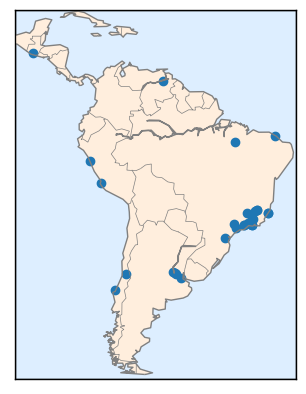

In [20]:




xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(coordinates_change(df_gspt)[:, 1], coordinates_change(df_gspt)[:, 0])

In [26]:
coordinates_world=coordinates_change(df_gspt)

In [29]:
kde = KernelDensity(bandwidth=0.03, metric='haversine',kernel='exponential')
kde.fit(np.radians(coordinates_world))

KernelDensity(bandwidth=0.03, kernel='exponential', metric='haversine')

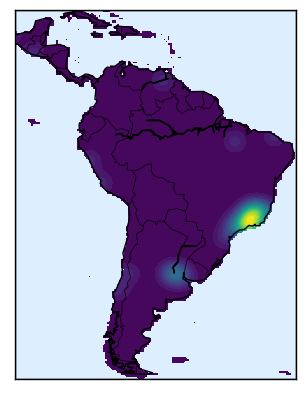

In [48]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 1)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)



    
    
    # plot coastlines with basemap
m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c')
m.drawmapboundary(fill_color='#DDEEFF')
m.drawcoastlines()
m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
kde = KernelDensity(bandwidth=0.03, metric='haversine',kernel='gaussian')
kde.fit(np.radians(coordinates_world))

    # evaluate only on the land: -9999 indicates ocean
Z = np.full(land_mask.shape[0], -9999.0)
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

    # plot contours of the density
levels = np.linspace(0, Z.max(), 25)
ax.contourf(X, Y, Z, levels=levels)